## Анализ данных для увеличения выручки интернет-магазина

В результате работы с отделом маркетинга подготовлен список гипотез для увеличения выручки.       
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

## План анализа данных      <a class="anchor" id="0-bullet">

### [1. Приоритизация гипотез](#a)   

- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета   

- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета   

- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло   


### [2. Анализ А/В-теста](#ab)   

[2.1. Откроем файлы и изучим данные](#abc)   

[2.2. Проанализируем А/В-тест:](#abcd)   

- Построить график кумулятивной выручки по группам   

- Построить график кумулятивного среднего чека по группам   

- Построить график относительного изменения кумулятивного среднего чека группы B к группе A   

- Построить график кумулятивной конверсии по группам    

- Построить график относительного изменения кумулятивной конверсии группы B к группе A   

- Построить точечный график количества заказов по пользователям   

- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей   

- Построить точечный график стоимостей заказов   

- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов    

- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным   

- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным   

- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным    

- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным    

[2.3. Примем решение по результатам А/В-теста](#abcde)    

Варианты решений:    

- 1. Остановить тест, зафиксировать победу одной из групп   
- 2. Остановить тест, зафиксировать отсутствие различий между группами   
- 3. Продолжить тест   

### [3. Вывод](#abcdef)

## 1.    Приоритизация гипотез <a name="a"></a>    
[*назад к оглавлению*](#0-bullet)     🚀

**Импортируем библиотеки**

In [138]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**Откроем файл и ознакомимся с данными**

In [139]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [140]:
pd.set_option('display.max_colwidth', -1)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Описание данных**   

- Hypothesis — краткое описание гипотезы   
- Reach — охват пользователей по 10-балльной шкале   
- Impact — влияние на пользователей по 10-балльной шкале   
- Confidence — уверенность в гипотезе по 10-балльной шкале   
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. *Чем больше значение Efforts, тем дороже проверка гипотезы*

**Применим фреймворк ICE для приоритизации гипотез**. Отсортируем их по убыванию приоритета

In [141]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Наиболее перспективные гипотезы по ICE: 9, 1, 8 и 7. Первое место - за 9-й гипотезой: *Запустить акцию, дающую скидку на товар в день рождения*

**Применим фреймворк RICE для приоритизации гипотез**. Отсортируем их по убыванию приоритета

In [142]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['ICE'] 
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Наиболее перспективные гипотезы по RICE: 8, 3, 1 и 7.   
Гипотеза под номером 9 исчезла из списка лидеров, вместо нее появилась 3-я гипотеза.   
Гипотеза 1 опустилась со второго на третье место.   
На первое место с третьего поднялась гипотеза под номером 8: *Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*. Это объясняется тем, что ее параметр `Reach` - охват пользователей - максимален и равен 10, в то время как у других гипотез он меньше.   
Раз охват 8 гипотезы максимален, установим ей высший приоритет и проведем ее А/В-тестирование с целью выяснить, увеличится ли выручка интернет-магазина при внедрении ее в жизнь

## 2.    Анализ А/В-теста <a name="ab"></a>    
[*назад к оглавлению*](#0-bullet)     🚀

### 2.1.   Откроем файлы и изучим данные <a name="abc"></a>    
[*назад к оглавлению*](#0-bullet)     🚀

In [143]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

**Изучим данные таблицы orders**

In [144]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


**Описание данных**   

- transactionId — идентификатор заказа   
- visitorId — идентификатор пользователя, совершившего заказ   
- date — дата, когда был совершён заказ   
- revenue — выручка заказа   
- group — группа A/B-теста, в которую попал заказ 

In [145]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [146]:
orders.duplicated().sum()

0

In [147]:
orders['date'].describe()

count     1197      
unique    31        
top       2019-08-05
freq      48        
Name: date, dtype: object

Данные таблицы `orders` не содержат пропусков и дубликатов. Информация о заказах за август 2019г. Типы данных всех столбцов, кроме `date`, корректны.    
Приведем тип данных столбца `date` к datetime

In [148]:
orders['date'] = pd.to_datetime(orders['date'])

**Изучим данные таблицы visitors**

In [149]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Описание данных**    

- date — дата   
- group — группа A/B-теста   
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [150]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [151]:
visitors.duplicated().sum()

0

In [152]:
visitors['date'].describe()

count     62        
unique    31        
top       2019-08-23
freq      2         
Name: date, dtype: object

Данные таблицы `visitors` не содержат пропусков и дубликатов. Информация о пользователях тоже за август 2019г. Типы данных всех столбцов, кроме `date`, корректны.    
Приведем тип данных столбца `date` к datetime

In [153]:
visitors['date'] = pd.to_datetime(visitors['date'])

### 2.2.  Проанализируем А/В-тест  <a name="abcd"></a>    
[*назад к оглавлению*](#0-bullet)     🚀

**Построим график кумулятивной выручки по группам**

Для нахождения кумулятивных по дням данных о заказах и посетителях интернет-магазина, создадим массив уникальных пар значений дата-группа теста

In [154]:
dateGroups = orders[['date', 'group']].drop_duplicates()

In [155]:
ordersAgg = dateGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date': 'max', 'group': 'max', 'transactionId': pd.Series.nunique, 'visitorId': pd.Series.nunique, 'revenue': 'sum'}), 
       axis=1).sort_values(by=['date', 'group'])

Посчитали агрегированные кумулятивные по дням данные о количестве заказов и сумме выручки

In [156]:
visitorsAgg = dateGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                 visitors['group'] == x['group'])]\
.agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

Посчитали агрегированные кумулятивные по дням данные о посетителях

In [157]:
cumData = ordersAgg.merge(visitorsAgg, on=['date', 'group'])
cumData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Объединили кумулятивные данные в одну таблицу

In [158]:
cumRevenueA = cumData.query('group =="A"')[['date', 'revenue', 'orders']]
cumRevenueB = cumData.query('group =="B"')[['date', 'revenue', 'orders']]

Построим графики кумулятивной выручки группы А и группы В    

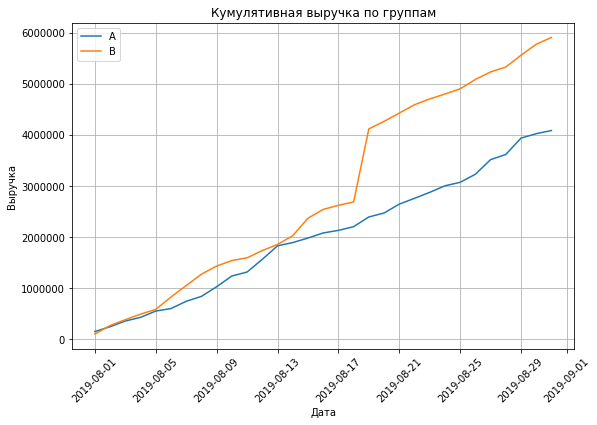

In [159]:
plt.figure(figsize=(9,6))
plt.plot(cumRevenueA['date'], cumRevenueA['revenue'], label='A')
plt.plot(cumRevenueB['date'], cumRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.grid()
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend();

Выручка в обеих группах с течением времени растет.   
Выручка группы А увеличивается плавно, равномерно.    
Выручка группы В растет сильнее, но  неравномерно. Видно, что 18-19 августа 2019г. в группе В был зафиксирован резкий скачек выручки вверх. Это может быть следствием всплеска числа заказов в интернет-магазине, либо появлением очень дорогих заказов. Эти выбросы надо проанализировать  

**Построим график кумулятивного среднего чека по группам**

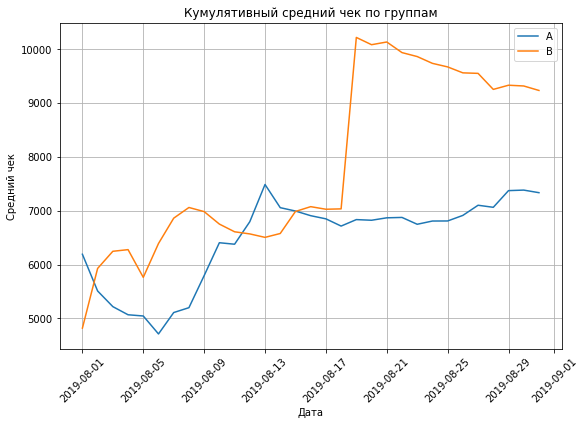

In [160]:
plt.figure(figsize=(9,6))
plt.plot(cumRevenueA['date'], cumRevenueA['revenue'] / cumRevenueA['orders'], label='A')
plt.plot(cumRevenueB['date'], cumRevenueB['revenue'] / cumRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.grid()
plt.title('Кумулятивный средний чек по группам')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend();

18-19 августа у группы В наблюдается тот же резкий всплеск среднего чека, что и всплеск выручки. После этих дат средний чек группы В постепенно снижается, а средний чек группы А наоборот - растет.   
На графике пока не видно, чтобы средние чеки по группам установились вокруг своих окончательных значений. Кажется, одного месяца наблюдений недостаточно 

**Построим график относительного изменения кумулятивного среднего чека группы B к группе A**

In [161]:
cumRevenue = cumRevenueA.merge(cumRevenueB, on='date', how='left', suffixes=['A', 'B'])

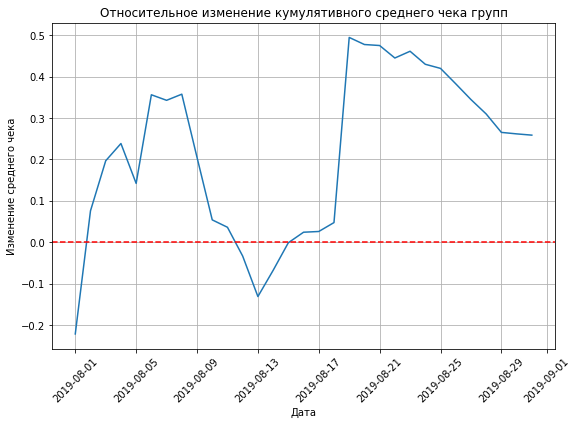

In [162]:
plt.figure(figsize=(9,6))
plt.plot(cumRevenue['date'], (cumRevenue['revenueB'] / cumRevenue['ordersB']) / 
                             (cumRevenue['revenueA'] / cumRevenue['ordersA']) - 1)
plt.xticks(rotation=45)
plt.grid()
plt.title('Относительное изменение кумулятивного среднего чека групп')
plt.ylabel('Изменение среднего чека')
plt.xlabel('Дата')
plt.axhline(y=0, color='red', linestyle='--');

График относительного изменения среднего чека колеблется. 06-08 августа и 19 августа средний чек группы В превысил средний чек группы А на 35% и 50% соответственно. А 13 августа наоборот сильно просел.   
Скорее всего это влияние выбросов - крупных заказов покупателей интернет-магазина то в одной, то в другой группе.   
К концу августа установилась тенденция: средний чек группы В превышает средний чек группы А на 25-30%, но разница между ними со временем уменьшается 

**Построим график кумулятивной конверсии по группам**

In [163]:
cumData['conversion'] = cumData['orders'] / cumData['visitors']
cumDataA = cumData.query('group == "A"')
cumDataB = cumData.query('group == "B"')

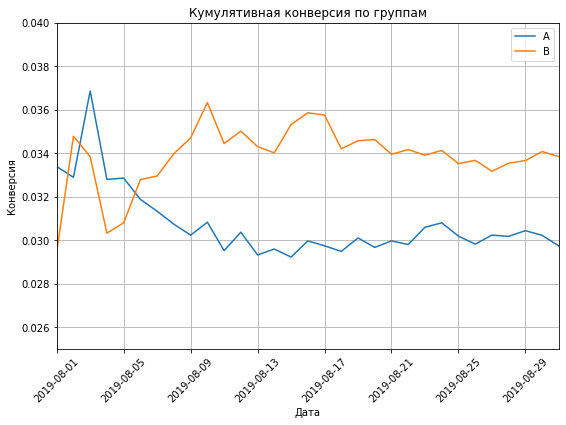

In [164]:
plt.figure(figsize=(9,6))
plt.plot(cumDataA['date'], cumDataA['conversion'], label='A')
plt.plot(cumDataB['date'], cumDataB['conversion'], label='B')
plt.xticks(rotation=45)
plt.grid()
plt.title('Кумулятивная конверсия по группам')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.legend()
plt.axis(['2019-08-01', '2019-08-31', 0.025, 0.04]);

В первых числах августа конверсии групп колебались вокруг одних значений. С 09 августа конверсия группы В установилась около значения 0.034 и зафиксировалась, а конверсия группы А установилась около значения 0.030 и зафиксировалась.       
Разница между конверсиями очень незначительная и составляет всего 0.4% = 3,4 % - 3% в пользу группы В

**Построим график относительного изменения кумулятивной конверсии группы B к группе A**

In [165]:
cumConversion = cumDataA[['date', 'conversion']].merge(cumDataB[['date', 'conversion']], on='date', suffixes=['A', 'B'])

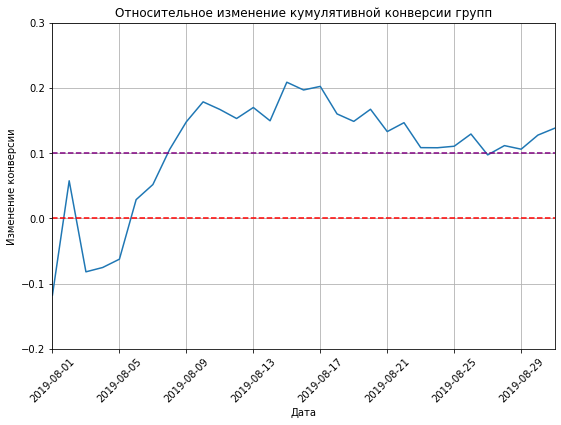

In [166]:
plt.figure(figsize=(9,6))
plt.plot(cumConversion['date'], cumConversion['conversionB'] / cumConversion['conversionA'] - 1)
plt.xticks(rotation=45)
plt.grid()
plt.title('Относительное изменение кумулятивной конверсии групп')
plt.ylabel('Изменение конверсии')
plt.xlabel('Дата')
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.1, color='purple', linestyle='--')
plt.axis(['2019-08-01', '2019-08-31', -0.2, 0.3]);

В начале теста конверсия группы В в основном была ниже конверсии группы А почти на 10%. С 06 августа группа В стала повышать свою конверсию относительно конверсии группы А вплоть до 20%. К концу августа превышение конверсии группы В над группой А стабилизировалось на уровне 10-15%

**Построим точечный график количества заказов по пользователям**

In [167]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsers.sort_values(by='transactionId', ascending=False).head()

,visitorId,transactionId
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Есть наиболее активные пользователи, которые сделали по 11, 9 и 8 покупок за август месяц. Посмотрим, сколько покупок делает средний пользователь

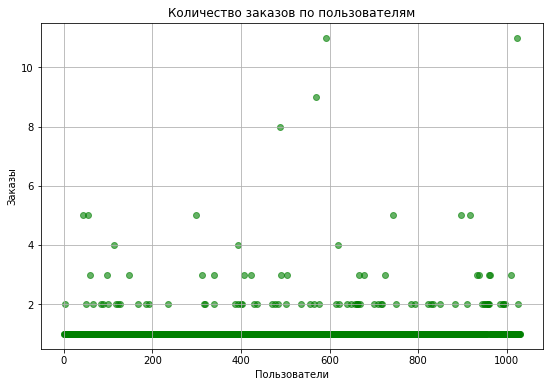

In [168]:
plt.figure(figsize=(9,6))
plt.scatter(pd.Series(range(0, len(ordersByUsers))), ordersByUsers['transactionId'], color='green', alpha=0.6)
plt.grid()
plt.title('Количество заказов по пользователям')
plt.ylabel('Заказы')
plt.xlabel('Пользователи');

Видно, что большинство пользователей ограничиваются одним заказом. Однако немало и тех, кто делают 2-3 заказа в интернет-магазине. Посмотрим, с какого количества заказов в месяц на пользователя их можно считать выбросами  

**Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей**

In [169]:
np.percentile(ordersByUsers['transactionId'], [95, 99])

array([2., 4.])

Не более 1% пользователей заказывали более 4-х раз. И не более 5% пользователей сделали два заказа в месяц.   
Установим границу для определения аномальных пользователей в **три заказа** 

**Построим точечный график стоимостей заказов**

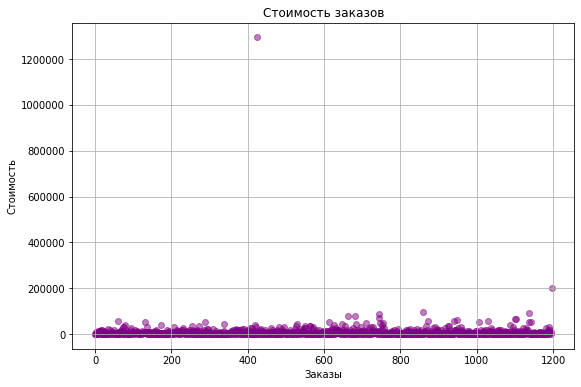

In [170]:
plt.figure(figsize=(9,6))
plt.scatter(pd.Series(range(0, len(orders))), orders['revenue'], color='purple', alpha=0.5)
plt.grid()
plt.title('Стоимость заказов')
plt.ylabel('Стоимость')
plt.xlabel('Заказы');

Стоимость большинства заказов не превышает 50 000 рублей. Найдем более точную величину стоимости заказа, являющуюся выбросом

**Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов**

In [171]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 1% заказов стоят дороже 58 233 рублей. И не более 5% заказов дороже 28 000 рублей. Выберем границу для определения аномальных заказов в размере **30 000 рублей**

**Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным**

Найдем для каждой группы количество пользователей в выбранную дату и количество пользователей до выбранной даты включительно

In [172]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [173]:
visitorsDailyA = visitors.query('group == "A"')[['date', 'visitors']]
visitorsDailyA.columns = ['date', 'visitorsDailyA']
visitorsDailyB = visitors.query('group == "B"')[['date', 'visitors']]
visitorsDailyB.columns = ['date', 'visitorsDailyB']

In [174]:
visitorsCumA = visitorsDailyA.apply(lambda x: visitorsDailyA[visitorsDailyA['date'] <= x['date']]\
                                           .agg({'date': 'max', 'visitorsDailyA': 'sum'}), axis=1)
visitorsCumA.columns = ['date', 'visitorsCumA']
visitorsCumB = visitorsDailyB.apply(lambda x: visitorsDailyB[visitorsDailyB['date'] <= x['date']]\
                                           .agg({'date': 'max', 'visitorsDailyB': 'sum'}), axis=1)
visitorsCumB.columns = ['date', 'visitorsCumB']

Найдем для каждой группы количество заказов и суммарную выручку за выбранную дату

In [175]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [176]:
ordersDailyA = orders.query('group == "A"')[['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', as_index=False)\
                                  .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
ordersDailyA.columns = ['date', 'ordersDailyA', 'revenueDailyA']
ordersDailyB = orders.query('group == "B"')[['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', as_index=False)\
                                  .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
ordersDailyB.columns = ['date', 'ordersDailyB', 'revenueDailyB']

Найдем для каждой группы суммарное число заказов и суммарную выручку до выбранной даты включительно

In [177]:
ordersCumA = ordersDailyA.apply(lambda x: ordersDailyA[ordersDailyA['date'] <= x['date']]\
             .agg({'date': 'max', 'ordersDailyA': 'sum', 'revenueDailyA': 'sum'}), axis=1).sort_values(by=['date'])
ordersCumA.columns = ['date', 'ordersCumA', 'revenueCumA']
ordersCumB = ordersDailyB.apply(lambda x: ordersDailyB[ordersDailyB['date'] <= x['date']]\
             .agg({'date': 'max', 'ordersDailyB': 'sum', 'revenueDailyB': 'sum'}), axis=1).sort_values(by=['date'])
ordersCumB.columns = ['date', 'ordersCumB', 'revenueCumB']

Объединим полученные данные в одну таблицу

In [178]:
test = ordersDailyA.merge(ordersDailyB, on='date', how='left')\
.merge(ordersCumA, on='date', how='left').merge(ordersCumB, on='date', how='left')\
.merge(visitorsDailyA, on='date', how='left').merge(visitorsDailyB, on='date', how='left')\
.merge(visitorsCumA, on='date', how='left').merge(visitorsCumB, on='date', how='left')
test.head()

,date,ordersDailyA,revenueDailyA,ordersDailyB,revenueDailyB,ordersCumA,revenueCumA,ordersCumB,revenueCumB,visitorsDailyA,visitorsDailyB,visitorsCumA,visitorsCumB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим для каждой группы выборку с указанием для каждого пользователя количества совершенных заказов

In [179]:
ordersByUsersA = orders.query('group == "A"').groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders.query('group == "B"').groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

In [180]:
sampleA = pd.concat([ordersByUsersA['orders'], 
          pd.Series(0, index=np.arange(test['visitorsDailyA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], 
          pd.Series(0, index=np.arange(test['visitorsDailyB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

Найдем относительный прирост конверсии группы В к конверсии группы А

In [181]:
sampleB.mean() / sampleA.mean() - 1

0.13807884655320146

Относительный прирост конверсии группы В к группе А очень хороший и составляет почти 14%.   
Для проверки полученных данных сформулируем нулевую гипотезу: *Конверсии групп А и В равны*.    
Тогда альтернативная гипотеза будет звучать так: *Конверсии групп А и В отличаются*

Группы А и В являются независимыми выборками. Так как мы будем проверять гипотезу на "сырых" данных, не очищенных от выбросов, применим **метод Манна-Уитни**. Он позволяет проранжировать две независимые выборки по порядку от меньшего к большему и сравнить ранги одних и тех же значений, попавших в обе выборки, никак не учитывая сами значения

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

In [182]:
stats.mannwhitneyu(sampleA, sampleB)[1]

0.008396177528376304

Статистическая значимость *p-value* меньше 1%, а значит и меньше критического уровня статистической значимости в 5%.   
Следовательно, мы отвергаем нулевую гипотезу о равенстве конверсий групп А и В.   
Значит, мы не отвергаем альтернативную гипотезу: ***Конверсии групп А и В отличаются***

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным**

Найдем относительное различие в среднем чеке между группами

In [183]:
orders.query('group == "B"')['revenue'].mean() / orders.query('group =="A"')['revenue'].mean() - 1

0.2587136699126005

Средний чек группы В на 26% выше среднего чека группы А.   
Для проверки полученных данных сформулируем нулевую гипотезу: *Средние чеки групп А и В равны*.   
Тогда альтернативная гипотеза будет звучать так: *Средние чеки групп А и В отличаются*

Применим **метод Манна-Уитни** для проверки гипотезы на "сырых" данных

In [184]:
stats.mannwhitneyu(orders.query('group =="A"')['revenue'], orders.query('group =="B"')['revenue'])[1]

0.3646454927716229

Статистическая значимость *p-value* более 36%, что значительно больше критического уровня статистической значимости в 5%. 
Следовательно, мы не отвергаем нулевую гипотезу: ***Средние чеки групп А и В равны***.    
Альтернативную гипотезу о различии средних чеков групп А и В отвергаем.   
По-видимому на величину среднего чека группы В серьезно влияют выбросы. Поэтому надо проверить метрики конверсии и среднего чека групп по "очищенным" от выбросов данным       

**Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным**

Найдем пользователей, совершивших более двух заказов или чьи заказы стоили дороже 30 000 рублей  

In [185]:
undueOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], 
                         ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis=0)
undueCosts = orders[orders['revenue'] > 30000]['visitorId']
undueUsers = pd.concat([undueOrders, undueCosts], axis=0).drop_duplicates().sort_values()
len(undueUsers)

68

Всего 68 аномальных пользователей. Очистим выборки от выбросов по группам теста

In [186]:
sampleCleanA = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(undueUsers))]['orders'], 
            pd.Series(0, index=np.arange(test['visitorsDailyA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleCleanB = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(undueUsers))]['orders'], 
            pd.Series(0, index=np.arange(test['visitorsDailyB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

Найдем относительный прирост конверсии группы В к конверсии группы А уже в "очищенных" данных 

In [187]:
sampleCleanB.mean() / sampleCleanA.mean() - 1

0.17155456396208346

Относительный прирост конверсии группы В к группе А увеличился на 3% по сравнению с "сырыми" данными и составляет более 17%.     
Сформулируем нулевую гипотезу: *Конверсии групп А и В равны*.    
Тогда альтернативная гипотеза будет звучать так: *Конверсии групп А и В отличаются*

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным **методом Манна-Уитни**

In [188]:
stats.mannwhitneyu(sampleCleanA, sampleCleanB)[1]

0.006671296868564326

Результаты по конверсии практически не изменились. Статистическая значимость *p-value* по-прежнему меньше 1%, а значит и меньше критического уровня статистической значимости в 5%.      
Следовательно, мы отвергаем нулевую гипотезу о равенстве конверсий групп А и В.      
Значит, мы не отвергаем альтернативную гипотезу: ***Конверсии групп А и В отличаются***

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным**

Найдем относительное различие в среднем чеке между группами

In [189]:
(orders[np.logical_and(orders['group'] == "B", np.logical_not(orders['visitorId'].isin(undueUsers)))]['revenue'].mean() / 
 orders[np.logical_and(orders['group'] == "A", np.logical_not(orders['visitorId'].isin(undueUsers)))]['revenue'].mean() - 1)

-0.023100874648026126

Получили совсем другую величину. В "сырых" данных средний чек группы В на 26% превышал средний чек группы А. В "очищенных" данных средний чек группы В уже меньше среднего чека группы А на 2%, то есть почти не отличается от него.      
Для проверки полученных данных сформулируем нулевую гипотезу: *Средние чеки групп А и В равны*.   
Тогда альтернативная гипотеза будет звучать так: *Средние чеки групп А и В отличаются*

In [190]:
stats.mannwhitneyu(orders[np.logical_and(orders['group'] == "A", 
                                         np.logical_not(orders['visitorId'].isin(undueUsers)))]['revenue'], 
                   orders[np.logical_and(orders['group'] == "B", 
                                         np.logical_not(orders['visitorId'].isin(undueUsers)))]['revenue'])[1]

0.36023324990535166

Результаты по среднему чеку практически не изменились. Статистическая значимость *p-value* по-прежнему 36%, что значительно больше критического уровня статистической значимости в 5%.   
Следовательно, мы не отвергаем нулевую гипотезу: ***Средние чеки групп А и В равны.***   
Альтернативную гипотезу о различии средних чеков групп А и В отвергаем.   
Теперь, после удаления выбросов из тестируемых групп, результат проверки различий средних чеков групп на статистическую значимость очевиден. В результате проведенного А/В-теста средний чек в группе В не отличается от среднего чека группы А

### 2.3.  Примем решение по результатам А/В-теста  <a name="abcde"></a>    
[*назад к оглавлению*](#0-bullet)     🚀

Проанализируем полученные результаты.     

- Обнаружено статистически значимое различие по конверсии между группами, как по "сырым", так и по "очищенным" данным. Конверсия группы В превышает конверсию группы А на 17%.  

- Отсутствует статистически значимое различие по среднему чеку заказа между группами А и В. Особенно очевидным стало равенство средних чеков после фильтрации выбросов.      

- Судя по графику различия конверсии между группами можно сделать вывод, что результаты группы В лучше группы А: к концу теста превышение конверсии группы В над группой А стабилизировалось на уровне 10-15%.   

- График различия среднего чека сильно колеблется из-за выбросов и сделать определенные выводы по нему нельзя. Он показывает превышение среднего чека группы В над средним чеком группы А на 25-30%. Однако, как показал метод Манна-Уитни, этот показатель вызван выбросами и не соответствует реальным значениям.   

Таким образом, группа В хоть и обладает схожим средним чеком заказа со средним чеком группы А, но за счет более высокой конверсии посетителей в покупатели, приносит бОльшую прибыль интернет-магазину. А/В-тест можно признать успешным, группу В - победителем, тест можно остановить.  

## 3.  Вывод  <a name="abcdef"></a>    
[*назад к оглавлению*](#0-bullet)     🚀

Перед нами стояла задача из подготовленного списка гипотез выбрать наиболее продуктивную гипотезу для увеличения выручки интернет-магазина, провести А/В-тест и проанализировать его результаты.    

У нас в распоряжении было 9 гипотез, как увеличить выручку интернет-магазина. В качестве методов упорядочивания экспериментов были выбраны способы ICE и RICE. Наиболее перспективные гипотезы по ICE: 9, 1, 8 и 7. Первое место - за 9-й гипотезой: Запустить акцию, дающую скидку на товар в день рождения.   

Наиболее перспективные гипотезы по RICE: 8, 3, 1 и 7. На первое место поднялась гипотеза под номером 8: ***Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок***. Это объясняется тем, что ее параметр `Reach` максимален и равен 10, в то время как у других гипотез он меньше. Раз охват 8 гипотезы максимален, гипотезе был установлен высший приоритет и проведено ее А/В-тестирование с целью выяснить, увеличится ли с ее помощью выручка интернет-магазина.      

Был проведен в течение августа месяца А/В-тест выбранной гипотезы. Результаты теста представлены в двух таблицах: `orders` и `visitors`. Данные таблиц `orders` и `visitors` не содержат пропусков и дубликатов. Типы данных всех столбцов, кроме `date`, корректны. Тип данных столбца `date` был приведен к datetime.      

График кумулятивной выручки группы А и группы В показал, что выручка в обеих группах с течением времени растет. Выручка группы А увеличивается плавно, равномерно. Выручка группы В расчет сильнее, но неравномерно. 18-19 августа 2019г. в группе В был зафиксирован резкий скачек выручки вверх. Это могло быть следствием всплеска числа заказов в интернет-магазине, либо появлением очень дорогих заказов.    

График кумулятивного среднего чека по группам показал, что 18-19 августа у группы В наблюдался тот же резкий всплеск среднего чека, что и всплеск выручки. После этих дат средний чек группы В постепенно снижался, а средний чек группы А наоборот - рос.
По графику сложно сказать, что средние чеки по группам установились вокруг своих окончательных значений.    


График относительного изменения кумулятивного среднего чека групп показал сильные колебания среднего чека в течение всего эксперимента. Скорее всего это влияние выбросов - крупных заказов покупателей интернет-магазина то в одной группе, то в другой.     

График кумулятивной конверсии по группам показал, что с течением времени конверсия группы В установилась около 3,4% и зафиксировалась, а конверсия группы А установилась около 3% и зафиксировалась. Разница между конверсиями незначительная и составляет 0.4% в пользу группы В.      

График относительного изменения кумулятивной конверсии групп подтвердил превосходство группы В. К концу августа превышение конверсии группы В над группой А стабилизировалось на уровне 10-15%.      

Не более 1% пользователей заказывали более 4-х раз. И не более 5% пользователей сделали два заказа в месяц. **Граница для определения аномальных пользователей  - три заказа.**    
Не более 1% заказов стоят дороже 58 233 рублей. И не более 5% заказов дороже 28 000 рублей. **Граница для определения аномальных заказов - в размере 30 000 рублей.**   

Для установления статистически значимого различия основных метрик А/В-теста: конверсии в заказы и среднего чека заказа был применен **метод Манна-Уитни**. В результате статистического анализа пришли к следующим выводам:              

- Обнаружено статистически значимое различие по конверсии между группами, как по "сырым", так и по "очищенным" от выбросов данным. **Конверсия группы В превышает конверсию группы А на 17%**.     

- **Отсутствует статистически значимое различие по среднему чеку заказа между группами А и В**. Особенно очевидным стало равенство средних чеков после фильтрации выбросов.         

- Судя по графику различия конверсии между группами можно сделать вывод, что результаты группы В лучше группы А: к концу теста превышение конверсии группы В над группой А стабилизировалось на уровне 10-15%.      

- График различия среднего чека сильно колеблется из-за выбросов и сделать определенные выводы по нему нельзя. Он показывает превышение среднего чека группы В над средним чеком группы А на 25-30%. Однако, как показал метод Манна-Уитни, этот показатель вызван выбросами и не соответствует реальным значениям.      

**Таким образом, группа В хоть и обладает схожим средним чеком со средним чеком группы А, но за счет более высокой конверсии в заказы, приносит бОльшую прибыль интернет-магазину.   
А/В-тест можно признать успешным, группу В - победителем, тест можно остановить.**   